In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [3]:
class ResetMcl(Mcl):
    def __init__(self, envmap,  init_pose,num, motion_noise_stds = {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},\
                distance_dev_rate = 0.14, direction_dev = 0.05, alpha_threshold = 0.001):
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold # αの記録（ランドマークの観測数ごと）
        
    def random_reset(self):
        for p in self.particles:
            p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
            p.weight = 1 / len(self.particles)
        
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
            
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.random_reset()
            
        else:
            self.resampling()
        """
        # αの記録
        alpha = sum([p.weight for p in self.particles])
        obsnum = len(observation)
        if not obsnum in self.alphas: self.alphas[obsnum] = []
        self.alphas[obsnum].append(alpha)
        
        self.set_ml()
        self.resampling() # 重みの合計１
        """

<IPython.core.display.Javascript object>


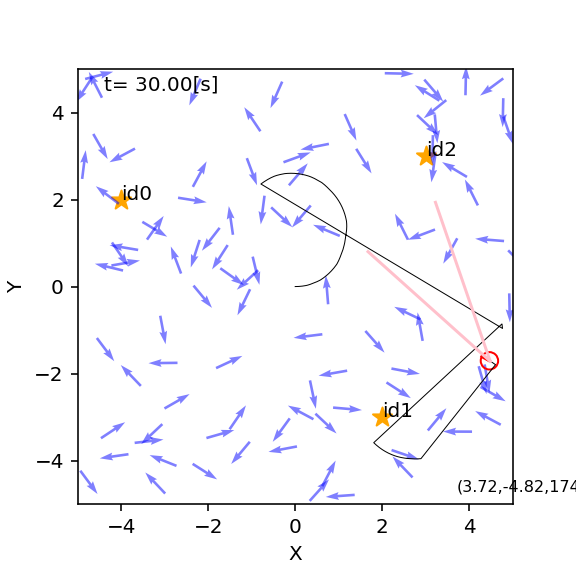

(array([0, 0, 0]), array([0, 0, 0]))

In [7]:
def trial(animation):
    time_interval = 0.1
    world = World(30,time_interval,debug = not animation)
    
    m = Map()
    for ln in [(-4,2),(2,-3),(3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)
    
    initial_pose = np.array([0,0,0]).T
    pf = ResetMcl(m, initial_pose, 100)
    a = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,pf)
    #r = Robot(initial_pose,sensor = Camera(m),agent = a,color = "red") # このカメラ、ファントム、オクルージョン...全部込み込み 誘拐なし
    r = Robot(initial_pose,sensor = Camera(m),agent = a, expected_kidnap_time = 10.0,color = "red") #  誘拐あり
    
    world.append(r)
    
    world.draw()
    return (r.pose, pf.pose)
    
trial(True)

In [ ]:
# 研究室のパソコンでうごかしたい